# Análisis de Datos de Netflix
A continuación se realiza un análisis de los datos de Netflix, incluyendo un test de normalidad utilizando el Test de Shapiro-Wilk
y un Análisis de Componentes Principales (PCA).

Primero se importan las bibliotecas necesarias:

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import kstest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Cargamos los datos de nuestra base de datos.

In [69]:
# Leer el archivo CSV completo
df = pd.read_csv('netflix_titles.csv')
print('Una muestra de las primeras filas:')
df.head()

Una muestra de las primeras filas:


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


## Funciones Utilitarias
La función `convert_duration` se utiliza para convertir la duración de las películas y series de TV en minutos o número de temporadas.

In [70]:
# utils.py
def convert_duration(duration):
    if pd.isna(duration):
        return 0
    if 'min' in duration:
        return int(duration.replace(' min', ''))
    elif 'Season' in duration:
        return int(duration.split(' ')[0])  # Asumimos 1 temporada
    return 0

## Estadísticas Descriptivas

### 1. Media

**Descripción Matemática**:
La **media** es el promedio aritmético de un conjunto de datos. Se calcula sumando todos los valores y dividiendo entre el número de valores.

**Fórmula**:
$$
\bar{x} = \frac{1}{N} \sum_{i=1}^{N} x_i
$$

**Uso**:
La media es una medida de tendencia central que nos indica el valor promedio de un conjunto de datos. Es útil para entender el punto medio alrededor del cual se distribuyen los datos. Sin embargo, puede verse afectada por valores atípicos (extremos).

**Descripción**:
Proporciona una visión general del "centro" de los datos. En contextos como el tiempo de duración de películas o series, la media indica cuánto tiempo dura, en promedio, una película o serie.

### 2. Mediana

**Descripción Matemática**:
La **mediana** es el valor central de un conjunto de datos cuando estos están ordenados de menor a mayor.

**Cálculo**:
- Si \( N \) es impar:
$$
\text{Mediana} = x_{\left( \frac{N+1}{2} \right)}
$$
- Si \( N \) es par:
$$
\text{Mediana} = \frac{x_{\left( \frac{N}{2} \right)} + x_{\left( \frac{N}{2} + 1 \right)} }{2}
$$

**Uso**:
La mediana es útil para entender la posición central de los datos y es menos sensible a los valores atípicos que la media. Es especialmente útil en distribuciones sesgadas.

**Descripción**:
Proporciona una medida central que no se ve influenciada por valores extremos. Es ideal para datos que no están distribuidos simétricamente.

### 3. Moda

**Descripción Matemática**:
La **moda** es el valor que ocurre con mayor frecuencia en un conjunto de datos.

**Cálculo**:
Identificar el valor que aparece más veces en el conjunto de datos.

**Uso**:
La moda es útil para identificar los valores más comunes en el conjunto de datos. Es especialmente relevante en datos categóricos y discretos.

**Descripción**:
Indica qué valor es más frecuente en el conjunto de datos. En el contexto de duraciones, mostraría la duración que más comúnmente tienen las películas o series.

### 4. Varianza

**Descripción Matemática**:
La **varianza** mide la dispersión de los datos respecto a la media. Representa el promedio de las diferencias cuadráticas de la media.

**Fórmula**:
$$
\sigma^2 = \frac{1}{N} \sum_{i=1}^{N} (x_i - \bar{x})^2
$$

**Uso**:
La varianza nos da una idea de cuánto varían los datos en relación con la media. Es fundamental para calcular la desviación estándar y otras medidas de dispersión.

**Descripción**:
Proporciona una medida de la variabilidad o dispersión de los datos respecto a la media. Es importante para entender la extensión de las diferencias en los datos.

### 5. Desviación Estándar

**Descripción Matemática**:
La **desviación estándar** es la raíz cuadrada de la varianza y mide la dispersión de los datos respecto a la media.

**Fórmula**:
$$
\sigma = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_i - \bar{x})^2}
$$


**Uso**:
La desviación estándar nos indica cuánto se desvían los datos de la media en promedio. Es una medida de dispersión que se expresa en las mismas unidades que los datos originales.

**Descripción**:
Proporciona una medida clara de la variabilidad de los datos. Es útil para entender la dispersión general en relación con la media.

### 6. Percentil 25 (Primer Cuartil)

**Descripción Matemática**:
El **percentil 25** es el valor debajo del cual se encuentra el 25% de los datos. También conocido como el primer cuartil.

**Cálculo**:
Ordenar los datos y encontrar el valor en la posición \( \left( 0.25 \times (N+1) \right) \)-ésima.

**Uso**:
El percentil 25 nos proporciona una medida de la posición relativa de los datos. Es útil para identificar el primer cuarto de la distribución de los datos.

**Descripción**:
Indica el valor por debajo del cual se encuentran el 25% de los datos. En términos prácticos, nos ayuda a entender la dispersión y la distribución de los datos en la parte baja de la muestra.

### 7. Percentil 50 (Mediana) y 75
**Descripción**: Segundo y tecer cuartil respectivamente, son análogos al percentil 25, siendo el percentil 50 equivalente a la mediana por definición.

### Guía del código
- Conversión de Duración: Convierte la duración de las películas y series de TV en minutos o temporadas utilizando la función convert_duration.

- Conversión de Fecha: Convierte la fecha en que se añadió el contenido a Netflix en un formato de fecha y extrae el año.

- Filtrado por Tipo de Contenido: Filtra el DataFrame original para separar las películas y las series de TV.

- Cálculo de Estadísticas: Calcula diversas estadísticas descriptivas (media, mediana, moda, varianza, desviación estándar, percentiles) para la duración, el año de estreno y el año de adición a Netflix. Los resultados se almacenan en un diccionario stats.

In [ ]:
# statistics.py
def calculate_statistics(df):
    df['duration_minutes'] = df['duration'].apply(convert_duration)
    df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
    df['year_added'] = df['date_added'].apply(lambda x: x.year if pd.notna(x) else None)

    movie_df = df[df['type'] == 'Movie']
    tv_show_df = df[df['type'] == 'TV Show']

    stats = {
        "Duración de Películas": {
            "Duración Media": round(movie_df['duration_minutes'].mean(), 3),
            "Duración Mediana": round(movie_df['duration_minutes'].median(), 3),
            "Moda de la Duración": movie_df['duration_minutes'].mode()[0],
            "Varianza (min^2)": round(movie_df['duration_minutes'].var(), 3),
            "Desviación Estándar": round(movie_df['duration_minutes'].std(), 3),
            "Percentil 25": round(movie_df['duration_minutes'].quantile(0.25), 3),
            "Percentil 50 (mediana)": round(movie_df['duration_minutes'].quantile(0.50), 3),
            "Percentil 75": round(movie_df['duration_minutes'].quantile(0.75), 3)
        },
        "Duración de Series de TV": {
            "Duración Media": round(tv_show_df['duration_minutes'].mean(), 3),
            "Duración Mediana": round(tv_show_df['duration_minutes'].median(), 3),
            "Moda de la Duración": tv_show_df['duration_minutes'].mode()[0],
            "Varianza (#temporadas^2)": round(tv_show_df['duration_minutes'].var(), 3),
            "Desviación Estándar": round(tv_show_df['duration_minutes'].std(), 3),
            "Percentil 25": round(tv_show_df['duration_minutes'].quantile(0.25), 3),
            "Percentil 50 (mediana)": round(tv_show_df['duration_minutes'].quantile(0.50), 3),
            "Percentil 75": round(tv_show_df['duration_minutes'].quantile(0.75), 3)
        },
        "Año de Estreno": {
            "Mediana": round(df['release_year'].median()),
            "Moda": df['release_year'].mode()[0],
            "Varianza": round(df['release_year'].var()),
            "Desviación Estándar": round(df['release_year'].std()),
            "Percentil 25": round(df['release_year'].quantile(0.25)),
            "Percentil 50 (mediana)": round(df['release_year'].quantile(0.50)),
            "Percentil 75": round(df['release_year'].quantile(0.75))
        },
        "Año de Adición a Netflix": {
            "Mediana": round(df['year_added'].median()),
            "Moda": df['year_added'].mode()[0],
            "Varianza": round(df['year_added'].var()),
            "Desviación Estándar": round(df['year_added'].std()),
            "Percentil 25": round(df['year_added'].quantile(0.25)),
            "Percentil 50 (mediana)": round(df['year_added'].quantile(0.50)),
            "Percentil 75": round(df['year_added'].quantile(0.75))
        }
    }

    return stats

# Calcular estadísticas
stats = calculate_statistics(df)

# Mostrar las estadísticas de duración de películas
print("Estadísticas de Duración de Películas")
display(pd.DataFrame(stats['Duración de Películas'], index=[0]).transpose())

# Mostrar las estadísticas de duración de series de TV
print("Estadísticas de Duración de Series de TV")
display(pd.DataFrame(stats['Duración de Series de TV'], index=[0]).transpose())

# Mostrar las estadísticas de año de estreno
print("Estadísticas del Año de Estreno")
display(pd.DataFrame(stats['Año de Estreno'], index=[0]).transpose())

# Mostrar las estadísticas de año de adición a Netflix
print("Estadísticas del Año de Adición a Netflix")
display(pd.DataFrame(stats['Año de Adición a Netflix'], index=[0]).transpose())



Estadísticas de Duración de Películas


,0
Duración Media,99.528
Duración Mediana,98.000
Moda de la Duración,90.000
Varianza (min^2),804.816
Desviación Estándar,28.369
Percentil 25,87.000
Percentil 50 (mediana),98.000
Percentil 75,114.000


Estadísticas de Duración de Series de TV


,0
Duración Media,1.765
Duración Mediana,1.000
Moda de la Duración,1.000
Varianza (#temporadas^2),2.505
Desviación Estándar,1.583
Percentil 25,1.000
Percentil 50 (mediana),1.000
Percentil 75,2.000


Estadísticas del Año de Estreno


,0
Mediana,2017
Moda,2018
Varianza,78
Desviación Estándar,9
Percentil 25,2013
Percentil 50 (mediana),2017
Percentil 75,2019


Estadísticas del Año de Adición a Netflix


,0
Mediana,2019.0
Moda,2019.0
Varianza,2.0
Desviación Estándar,2.0
Percentil 25,2018.0
Percentil 50 (mediana),2019.0
Percentil 75,2020.0


## Interpretación de Resultados

### Estadísticas de Duración de Películas

- Las películas en el conjunto de datos tienen una duración media de aproximadamente 99.5 minutos.
- La mediana, que es 98 minutos, está muy cerca de la media, indicando que la distribución de las duraciones es bastante simétrica.
- La moda, que es 90 minutos, sugiere que hay una alta frecuencia de películas con esta duración específica.
- La varianza y la desviación estándar indican que hay una dispersión considerable en las duraciones de las películas, con una desviación promedio de unos 28 minutos respecto a la media.
- Los percentiles muestran que el 25% de las películas duran menos de 87 minutos, el 50% menos de 98 minutos, y el 75% menos de 114 minutos.

### Estadísticas de Duración de Series de TV

- Las series de TV en el conjunto de datos tienen una duración media de aproximadamente 1.77 temporadas.
- La mediana y la moda, ambas de 1 temporada, indican que la mayoría de las series tienen una única temporada.
- La varianza y la desviación estándar muestran que hay una dispersión considerable en el número de temporadas, con una desviación promedio de 1.58 temporadas respecto a la media.
- Los percentiles reflejan que el 25% de las series tienen menos de 1 temporada, el 50% tienen 1 temporada, y el 75% tienen hasta 2 temporadas.

### Estadísticas del Año de Estreno

- La mediana del año de estreno es 2017, lo que significa que la mitad de los contenidos fueron lanzados antes de 2017 y la otra mitad después.
- La moda, el año 2018, indica que más contenidos fueron lanzados en este año específico que en cualquier otro.
- La varianza y la desviación estándar indican una dispersión moderada en los años de estreno, con una desviación promedio de 9 años respecto a la media.
- Los percentiles muestran que el 25% de los contenidos fueron estrenados antes de 2013, el 50% antes de 2017, y el 75% antes de 2019.

### Estadísticas del Año de Adición a Netflix

- La mediana y la moda del año de adición a Netflix son ambas 2019, indicando que la mayoría de los contenidos fueron añadidos en ese año.
- La varianza y la desviación estándar muestran una baja dispersión en los años de adición, con una desviación promedio de 2 años respecto a la media.
- Los percentiles reflejan que el 25% de los contenidos fueron añadidos antes de 2018, el 50% antes de 2019, y el 75% antes de 2020.


## Directores y Países con Más Contenido
A continuación se muestran las funcionalidades para generar gráficos de los directores y países con más películas y con más series de TV.

### Efectuando los cálculos
Estas funciones filtran el DataFrame por tipo de contenido (Movie o TV Show) y cuentan la frecuencia de los directores/países. La función value_counts() cuenta la aparición de cada director/país, y nlargest(n) selecciona los n directores/países con más contenido. Los resultados se devuelven como una Serie de Pandas.

In [72]:
# Métodos para calcular directores con más contenido
def top_movie_directors(df, n=10):
    movie_director_counts = df[df['type'] == 'Movie']['director'].value_counts().nlargest(n)
    return movie_director_counts

def top_tv_show_directors(df, n=10):
    tv_show_director_counts = df[df['type'] == 'TV Show']['director'].value_counts().nlargest(n)
    return tv_show_director_counts

# Métodos para calcular países con más contenido
def top_movie_countries(df, n=10):
    movie_country_counts = df[df['type'] == 'Movie']['country'].value_counts().nlargest(n)
    return movie_country_counts

def top_tv_show_countries(df, n=10):
    tv_show_country_counts = df[df['type'] == 'TV Show']['country'].value_counts().nlargest(n)
    return tv_show_country_counts


### Generando los gráficos
Estas funciones crean gráficos de barras para visualizar los directores/países con más contenido. Se utiliza seaborn.barplot para generar el gráfico, con los valores de frecuencia en el eje x y los nombres de los directores/países en el eje y. El parámetro hue se utiliza para desactivar la leyenda.

Top Directores de Películas con Más Contenidos


director
Rajiv Chilaka             19
Raúl Campos, Jan Suter    18
Suhas Kadav               16
Marcus Raboy              15
Jay Karas                 14
Cathy Garcia-Molina       13
Martin Scorsese           12
Youssef Chahine           12
Jay Chapman               12
Steven Spielberg          11
Name: count, dtype: int64

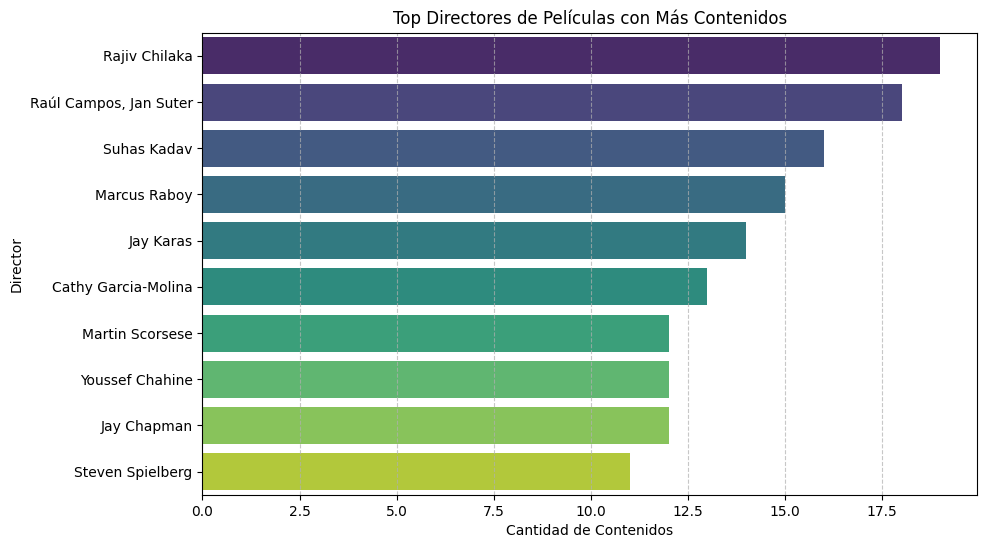

Top Directores de Series de TV con Más Contenidos


director
Alastair Fothergill    3
Rob Seidenglanz        2
Hsu Fu-chun            2
Iginio Straffi         2
Shin Won-ho            2
Ken Burns              2
Stan Lathan            2
Thomas Astruc          1
Quek Shio-chuan        1
Elías León             1
Name: count, dtype: int64

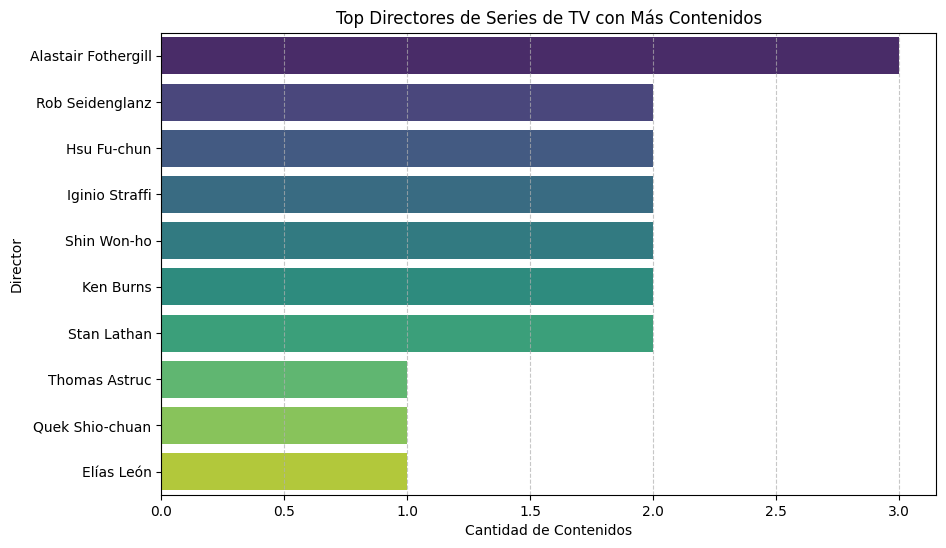

Top Países de Películas con Más Contenidos


country
United States     2058
India              893
United Kingdom     206
Canada             122
Spain               97
Egypt               92
Nigeria             86
Indonesia           77
Turkey              76
Japan               76
Name: count, dtype: int64

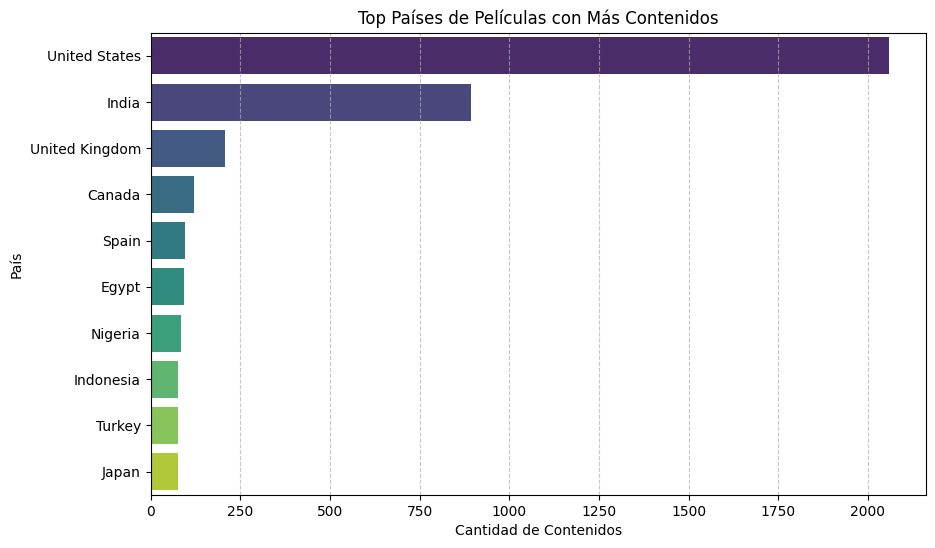

Top Países de Series de TV con Más Contenidos


country
United States     760
United Kingdom    213
Japan             169
South Korea       158
India              79
Taiwan             68
Canada             59
France             49
Australia          48
Spain              48
Name: count, dtype: int64

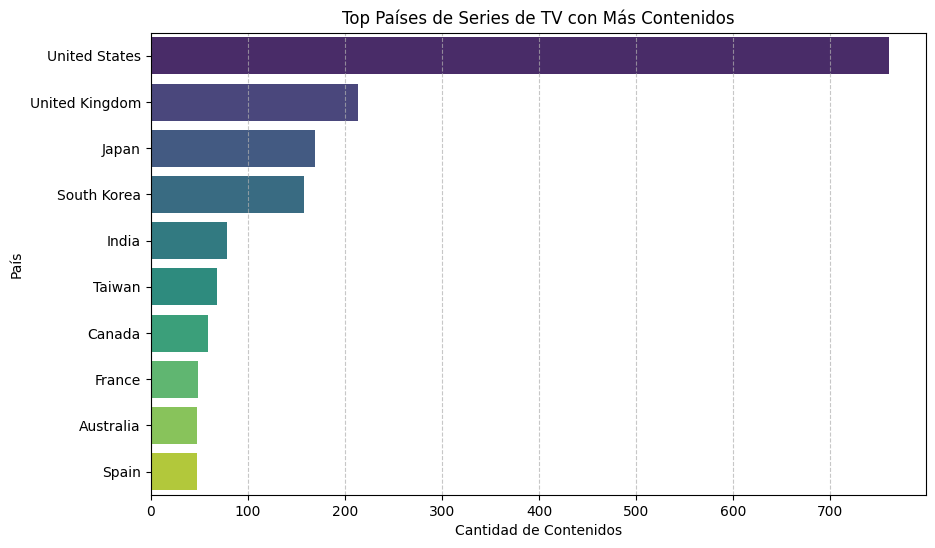

In [73]:
# Métodos para graficar directores con más contenido
def plot_top_movie_directors(movie_director_counts):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=movie_director_counts.values, y=movie_director_counts.index, palette='viridis', hue=movie_director_counts.index, dodge=False, legend=False)
    plt.title('Top Directores de Películas con Más Contenidos')
    plt.xlabel('Cantidad de Contenidos')
    plt.ylabel('Director')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

def plot_top_tv_show_directors(tv_show_director_counts):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=tv_show_director_counts.values, y=tv_show_director_counts.index, palette='viridis', hue=tv_show_director_counts.index, dodge=False, legend=False)
    plt.title('Top Directores de Series de TV con Más Contenidos')
    plt.xlabel('Cantidad de Contenidos')
    plt.ylabel('Director')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

# Métodos para graficar países con más contenido
def plot_top_movie_countries(movie_country_counts):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=movie_country_counts.values, y=movie_country_counts.index, palette='viridis', hue=movie_country_counts.index, dodge=False, legend=False)
    plt.title('Top Países de Películas con Más Contenidos')
    plt.xlabel('Cantidad de Contenidos')
    plt.ylabel('País')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

def plot_top_tv_show_countries(tv_show_country_counts):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=tv_show_country_counts.values, y=tv_show_country_counts.index, palette='viridis', hue=tv_show_country_counts.index, dodge=False, legend=False)
    plt.title('Top Países de Series de TV con Más Contenidos')
    plt.xlabel('Cantidad de Contenidos')
    plt.ylabel('País')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()


# Calcular los directores con más películas
movie_director_counts = top_movie_directors(df)
print("Top Directores de Películas con Más Contenidos")
display(movie_director_counts)

# Graficar los directores con más películas
plot_top_movie_directors(movie_director_counts)

# Calcular los directores con más series de TV
tv_show_director_counts = top_tv_show_directors(df)
print("Top Directores de Series de TV con Más Contenidos")
display(tv_show_director_counts)

# Graficar los directores con más series de TV
plot_top_tv_show_directors(tv_show_director_counts)

# Calcular los países con más películas
movie_country_counts = top_movie_countries(df)
print("Top Países de Películas con Más Contenidos")
display(movie_country_counts)

# Graficar los países con más películas
plot_top_movie_countries(movie_country_counts)

# Calcular los países con más series de TV
tv_show_country_counts = top_tv_show_countries(df)
print("Top Países de Series de TV con Más Contenidos")
display(tv_show_country_counts)

# Graficar los países con más series de TV
plot_top_tv_show_countries(tv_show_country_counts)

## Categorías Más Comunes

Se analizarán a continuación las categorías más frecuentes en el conjunto de datos de Netflix.

Categorías más comunes en Películas:


International Movies        2752
Dramas                      2427
Comedies                    1674
Documentaries                869
Action & Adventure           859
Independent Movies           756
Children & Family Movies     641
Romantic Movies              616
Thrillers                    577
Music & Musicals             375
Name: count, dtype: int64



Categorías más comunes en Series de TV:


International TV Shows    1351
TV Dramas                  763
TV Comedies                581
Crime TV Shows             470
Kids' TV                   451
Docuseries                 395
Romantic TV Shows          370
Reality TV                 255
British TV Shows           253
Anime Series               176
Name: count, dtype: int64

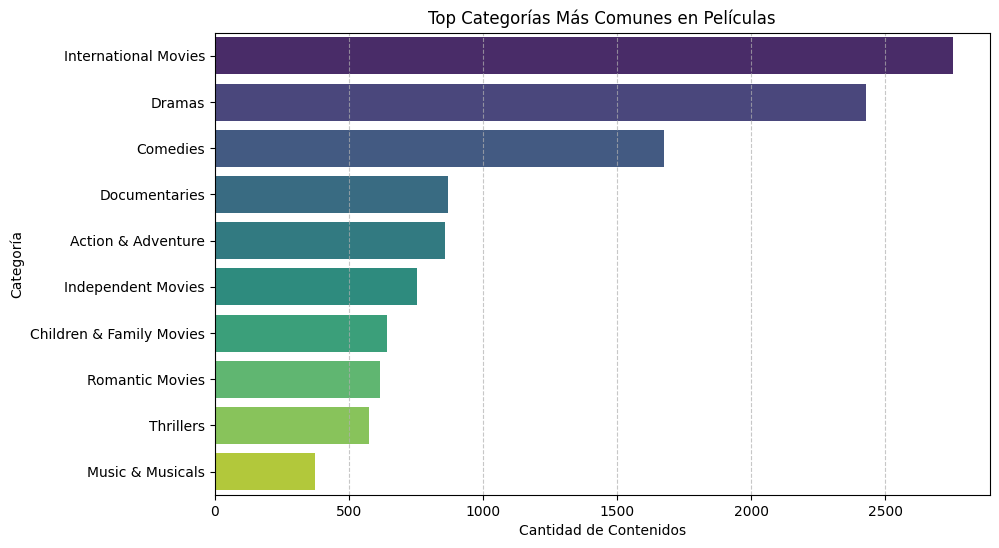

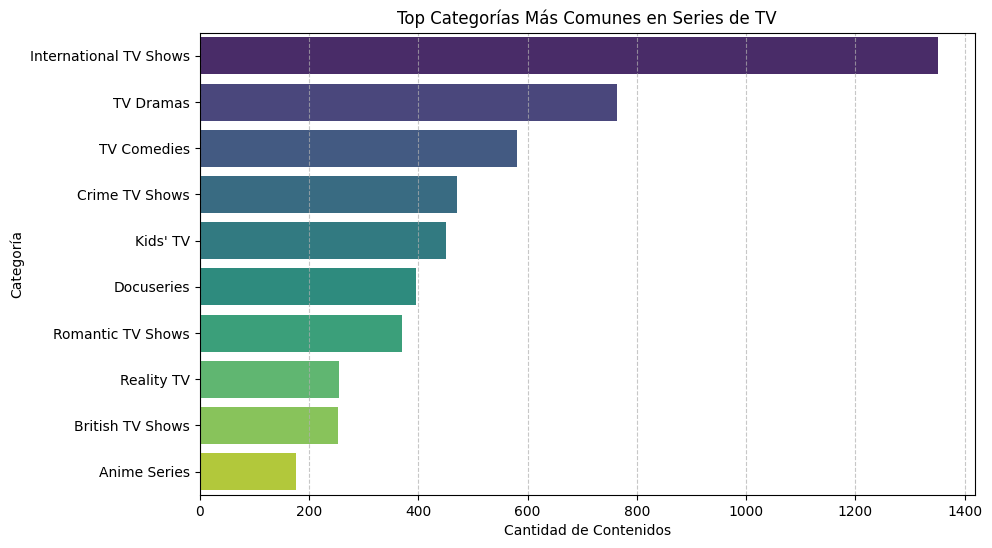

In [74]:
def calculate_category_counts_by_type(df, content_type):
    # Filtrar por tipo de contenido
    filtered_df = df[df['type'] == content_type]

    # Crear una lista vacía para almacenar las categorías
    all_categories = []

    # Recorrer cada fila en el DataFrame
    for categories in filtered_df['listed_in'].dropna():
        # Separar las categorías por coma y eliminar espacios en blanco
        category_list = [category.strip() for category in categories.split(',')]
        # Añadir las categorías a la lista
        all_categories.extend(category_list)

    # Contar la frecuencia de cada categoría
    category_counts = pd.Series(all_categories).value_counts()

    return category_counts

def plot_top_categories_by_type(category_counts, content_type, n=10):
    # Seleccionar las n categorías más comunes
    top_categories = category_counts.nlargest(n)

    # Crear el gráfico
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_categories.values, y=top_categories.index, hue=top_categories.index, palette='viridis', dodge=False, legend=False)
    plt.title(f'Top Categorías Más Comunes en {content_type}')
    plt.xlabel('Cantidad de Contenidos')
    plt.ylabel('Categoría')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
# Calcular las frecuencias de las categorías para películas
movie_category_counts = calculate_category_counts_by_type(df, 'Movie')

# Mostrar las categorías más comunes para películas
print("Categorías más comunes en Películas:")
display(movie_category_counts.head(10))
print('\n')
# Graficar las categorías más comunes para películas
plot_top_categories_by_type(movie_category_counts, 'Películas', n=10)

# Calcular las frecuencias de las categorías para series de TV
tv_show_category_counts = calculate_category_counts_by_type(df, 'TV Show')

# Mostrar las categorías más comunes para series de TV
print("Categorías más comunes en Series de TV:")
display(tv_show_category_counts.head(10))

# Graficar las categorías más comunes para series de TV
plot_top_categories_by_type(tv_show_category_counts, 'Series de TV', n=10)

## Test de Kolmogorov-Smirnov

La prueba de Kolmogorov-Smirnov (KS) es una prueba no paramétrica utilizada para determinar si una muestra proviene de una distribución de probabilidad específica, como la distribución normal. También se puede usar para comparar dos muestras.

### Objetivos de la Prueba KS

1. **Evaluar la Normalidad**: Determinar si una muestra sigue una distribución normal.
2. **Comparar Distribuciones**: Comparar dos distribuciones de muestras diferentes.

### Fundamentos Teóricos

#### Función de Distribución Acumulativa (CDF)
- La función de distribución acumulativa (CDF) de una variable aleatoria \(X\) es la probabilidad de que \(X\) sea menor o igual a un valor \(x\): \(F(x) = P(X <= x)\).

#### Función de Distribución Empírica (ECDF)
- Para una muestra de tamaño \(n\), la función de distribución empírica (ECDF) es la fracción de muestras menores o iguales a \(x\).

#### Estadístico de Prueba KS
- El estadístico de prueba de Kolmogorov-Smirnov es la distancia máxima entre la ECDF de la muestra y la CDF teórica de la distribución específica.
- Se define como:
  $$
  D_{n} = \sup_{x} |F_{n}(x) - F(x)|
  $$
  donde:
  - \( D_{n} \) es el estadístico de prueba.
  - \( F_{n}(x) \) es la ECDF de la muestra.
  - \( F(x) \) es la CDF teórica.

#### Hipótesis de la Prueba KS
- **Hipótesis Nula (H0)**: La muestra sigue la distribución específica.
- **Hipótesis Alternativa (H1)**: La muestra no sigue la distribución específica.

#### Valor P (p-value)
- El p-valor es la probabilidad de observar un estadístico de prueba tan extremo como el calculado, bajo la hipótesis nula.
- Si el p-valor es menor que el nivel de significancia (por ejemplo, \(\alpha = 0.05\)), se rechaza la hipótesis nula.

### Uso
Utilizaremos este test para determinar se las duraciones de las películas y series siguen una distribución normal.

In [75]:
# Preparar datos de películas y series de TV
df['duration_minutes'] = df[df['type'] == 'Movie']['duration'].apply(convert_duration)
df['duration_seasons'] = df[df['type'] == 'TV Show']['duration'].str.extract(r'(\d+)', expand=False).astype(float)

# Filtrar datos de películas y series de TV
movies_data = df[df['type'] == 'Movie']['duration_minutes'].dropna()
tv_shows_data = df[df['type'] == 'TV Show']['duration_seasons'].dropna()

# Prueba KS para películas
ks_statistic_movies, p_value_movies = kstest(movies_data, 'norm', args=(movies_data.mean(), movies_data.std()))

# Prueba KS para series de TV
ks_statistic_tv_shows, p_value_tv_shows = kstest(tv_shows_data, 'norm', args=(tv_shows_data.mean(), tv_shows_data.std()))

print("Prueba KS para Películas")
print("KS Statistic:", ks_statistic_movies)
print("p-value:", p_value_movies)

print("\nPrueba KS para Series de TV")
print("KS Statistic:", ks_statistic_tv_shows)
print("p-value:", p_value_tv_shows)


Prueba KS para Películas
KS Statistic: 0.08593300604226894
p-value: 7.727100215413908e-40

Prueba KS para Series de TV
KS Statistic: 0.3555893525557158
p-value: 2.8271494080313112e-303


## Visualización de los datos

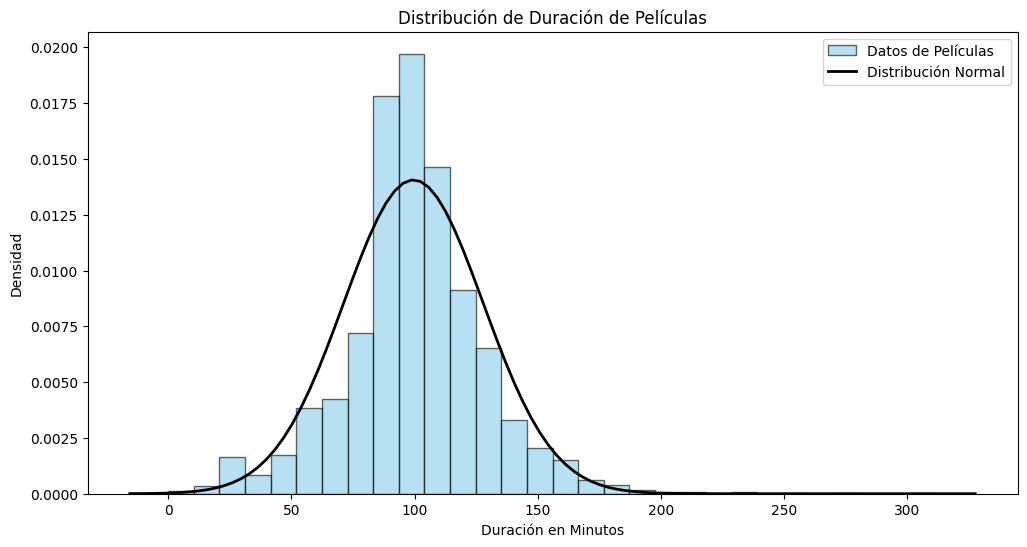

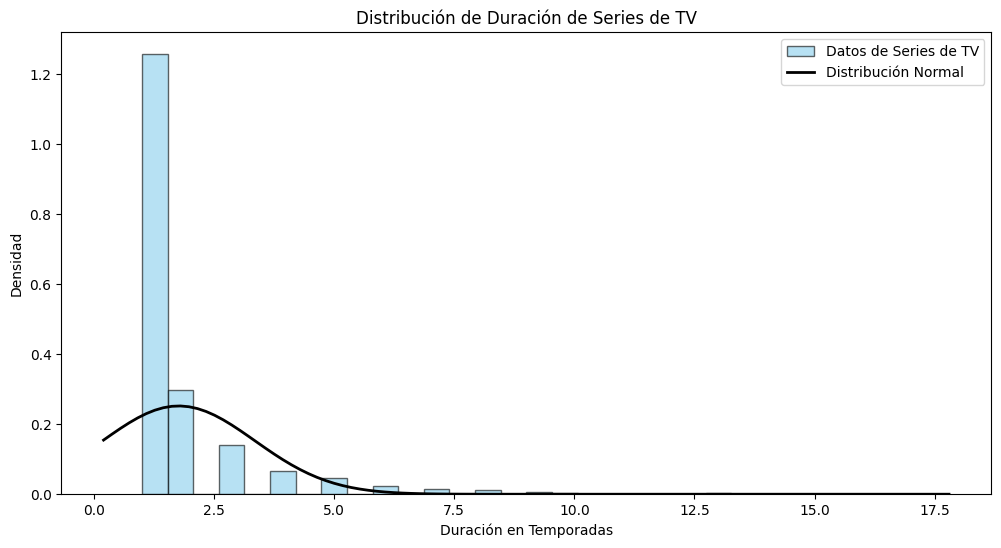

In [76]:
# Visualización para Películas
plt.figure(figsize=(12, 6))
plt.hist(movies_data, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Datos de Películas')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-0.5*((x - movies_data.mean())/movies_data.std())**2)/(movies_data.std() * np.sqrt(2*np.pi))
plt.plot(x, p, 'k', linewidth=2, label='Distribución Normal')
plt.title('Distribución de Duración de Películas')
plt.xlabel('Duración en Minutos')
plt.ylabel('Densidad')
plt.legend()
plt.show()

# Visualización para Series de TV
plt.figure(figsize=(12, 6))
plt.hist(tv_shows_data, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Datos de Series de TV')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-0.5*((x - tv_shows_data.mean())/tv_shows_data.std())**2)/(tv_shows_data.std() * np.sqrt(2*np.pi))
plt.plot(x, p, 'k', linewidth=2, label='Distribución Normal')
plt.title('Distribución de Duración de Series de TV')
plt.xlabel('Duración en Temporadas')
plt.ylabel('Densidad')
plt.legend()

## Interpretación de Resultados de la Prueba KS

### Prueba KS para Películas

**KS Statistic**: 0.08593300604226894  
**p-value**: 7.727100215413908e-40

**Interpretación**:
El valor del estadístico KS es 0.085933. Esto representa la mayor diferencia entre la función de distribución acumulativa empírica de las duraciones de las películas y la función de distribución acumulativa teórica de una distribución normal. El p-valor es extremadamente pequeño, casi 0. Dado que el p-valor es mucho menor que el nivel de significancia comúnmente utilizado (0.05), rechazamos la hipótesis nula de que las duraciones de las películas siguen una distribución normal. 

Esto indica que las duraciones de las películas en el conjunto de datos no se distribuyen normalmente.

### Prueba KS para Series de TV

**KS Statistic**: 0.3555893525557158  
**p-value**: 2.8271494080313112e-303

**Interpretación**:
Obtenemos resultados análogos a los anteriores. El valor del estadístico KS es 0.355589 y el p-valor es nuevamente muy pequeño, casi 0. Nuevamente rechazamos la hipótesis nula de que las duraciones de las series de TV siguen una distribución normal. 

### Resumen General

Ambas pruebas de Kolmogorov-Smirnov para películas y series de TV muestran que las duraciones de estos contenidos no siguen una distribución normal. Esto puede ser debido a que las duraciones están influenciadas por diferentes factores que no se alinean con una distribución normal, como la variedad de géneros, formatos y épocas de lanzamiento.

## Análisis de Componentes Principales (PCA)
El PCA es una técnica de reducción de dimensionalidad que se utiliza para transformar un conjunto de variables posiblemente correlacionadas en un conjunto más pequeño de variables no correlacionadas llamadas componentes principales. Es una técnica ampliamente utilizada en análisis exploratorio de datos y aprendizaje automático para simplificar conjuntos de datos complejos y facilitar su visualización.

## ¿Cómo funciona el PCA?
Estandarización de los Datos: Antes de aplicar PCA, es importante estandarizar los datos, especialmente si las variables tienen diferentes escalas. Esto se logra restando la media y dividiendo por la desviación estándar para cada variable.

### Cálculo de la Matriz de Covarianza:

La matriz de covarianza muestra cómo varían conjuntamente las variables y es una medida de la relación lineal entre ellas.

Se calcula utilizando la siguiente fórmula: $$ \mathbf{C} = \frac{1}{N-1} (\mathbf{X} - \bar{\mathbf{X}})^\top (\mathbf{X} - \bar{\mathbf{X}}) $$ donde:

𝐶
 es la matriz de covarianza.

𝑁
 es el número de observaciones.

𝑋
 es la matriz de datos estandarizados.

𝑋
ˉ
 es el vector de medias (que será cero debido a la estandarización).

### Cálculo de los Valores y Vectores Propios:

Se calculan los valores propios (eigenvalues) y los vectores propios (eigenvectors) de la matriz de covarianza.

Los valores propios indican la cantidad de varianza explicada por cada componente principal.

Los vectores propios indican la dirección de los componentes principales en el espacio original de las variables.

### Ordenamiento de Componentes:

Se ordenan los componentes principales en orden descendente según sus valores propios.

Los primeros componentes principales explican la mayor parte de la variabilidad en los datos.

### Selección de Componentes Principales:

Se decide cuántos componentes principales retener. Esto se puede hacer observando la varianza explicada acumulada y seleccionando los componentes que explican un porcentaje significativo de la variabilidad total (por ejemplo, el 90%).

### Transformación de los Datos:

Los datos originales se proyectan en el nuevo espacio de componentes principales seleccionados.

La nueva matriz de datos tendrá menos variables (componentes principales) pero retendrá la mayor parte de la información original.

# Explicación del código

### Preparación
- Filtra el DataFrame original df según el tipo de contenido (Movie o TV Show).

- Convierte la duración en minutos utilizando la función convert_duration.

- Extrae el año de adición a Netflix.

- Selecciona las columnas numéricas relevantes (duration_minutes, release_year, year_added) y elimina filas con valores nulos.

In [77]:
def prepare_data_for_pca(df, content_type):
    df['duration_minutes'] = df['duration'].apply(convert_duration)
    df['year_added'] = pd.to_datetime(df['date_added'], errors='coerce').dt.year
    df_filtered = df[df['type'] == content_type]
    numeric_columns = ['duration_minutes', 'release_year', 'year_added']
    data = df_filtered[numeric_columns].dropna()
    return data

### Realización
- Estandarización de los datos restando la media y dividiendo por la desviación estándar.

- Inicialización del objeto PCA con el número deseado de componentes principales (n_components).

- Ajuste del modelo PCA a los datos estandarizados y transformación los datos originales en componentes principales.

- Calcula las cargas de los componentes principales (loadings), que muestran cómo se combinan las variables originales para formar los componentes principales.

In [78]:
def perform_pca(data, n_components=None):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data_scaled)
    
    pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])
    loadings = pd.DataFrame(pca.components_, columns=data.columns, index=[f'PC{i+1}' for i in range(principal_components.shape[1])])
    
    return pca, pca_df, loadings

### Graficación
- Selecciona las columnas numéricas del DataFrame.

- Elimina las filas con valores nulos.

- Realiza el análisis de PCA llamando a la función pca_analysis.

- Grafica la varianza explicada llamando a la función plot_pca_variance.

- Devuelve el DataFrame con los componentes principales.

In [79]:
def plot_pca_variance(pca, content_type):
    plt.figure(figsize=(10, 6))
    components = range(1, len(pca.explained_variance_ratio_) + 1)
    var_exp = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(var_exp)
    
    plt.bar(components, var_exp, alpha=0.6, align='center', color='skyblue', label='Varianza Explicada por Componente')
    #plt.step(components, cum_var_exp, where='mid', color='orange', label='Varianza Explicada Acumulativa')
    plt.xlabel('Componentes Principales')
    plt.ylabel('Varianza Explicada')
    plt.title(f'Varianza Explicada por Cada Componente Principal ({content_type})')
    
    # Añadir etiquetas a las barras
    for i in range(len(components)):
        plt.text(components[i], var_exp[i], f'PC{i+1}', ha='center', va='bottom')
    
    plt.legend(loc='best')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

### Determinar el número de componentes
pca.explained_variance_ratio_ es un atributo del objeto PCA que contiene la proporción de varianza explicada por cada componente principal.

np.cumsum() calcula la suma acumulativa de estos valores. Así, cumulative_variance será un array donde cada elemento representa la varianza acumulativa explicada hasta ese componente principal.

cumulative_variance >= threshold crea un array booleano donde cada elemento es True si la varianza acumulada hasta ese componente es mayor o igual que el umbral (por ejemplo, 0.90) y False en caso contrario.

np.argmax() devuelve el índice del primer True en el array booleano. Este índice corresponde al número mínimo de componentes necesarios para alcanzar al menos el umbral de varianza explicada.

In [80]:
def determine_n_components(pca, threshold=0.90):
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    return n_components


### Ejecución

Componentes Principales para Películas (n=3)


,PC1,PC2,PC3
0,-0.263162,1.516421,-0.381562
1,-0.300777,1.572162,-0.295546
2,2.347157,0.177751,-1.218639
3,0.033601,1.607042,0.015894
4,0.625192,1.668754,0.566904


Cargas de los Componentes Principales para Películas


,duration_minutes,release_year,year_added
PC1,0.729636,-0.612926,0.303236
PC2,0.076111,0.513467,0.854727
PC3,0.679586,0.600561,-0.421295


Componentes Principales para Series de TV (n=3)


,PC1,PC2,PC3
0,1.464428,0.063138,0.335466
1,1.362023,-0.585756,0.483566
2,1.362023,-0.585756,0.483566
3,1.464428,0.063138,0.335466
4,1.362023,-0.585756,0.483566


Cargas de los Componentes Principales para Series de TV


,duration_minutes,release_year,year_added
PC1,0.152068,0.686293,0.711250
PC2,0.963591,-0.263069,0.047818
PC3,-0.219925,-0.678083,0.701311


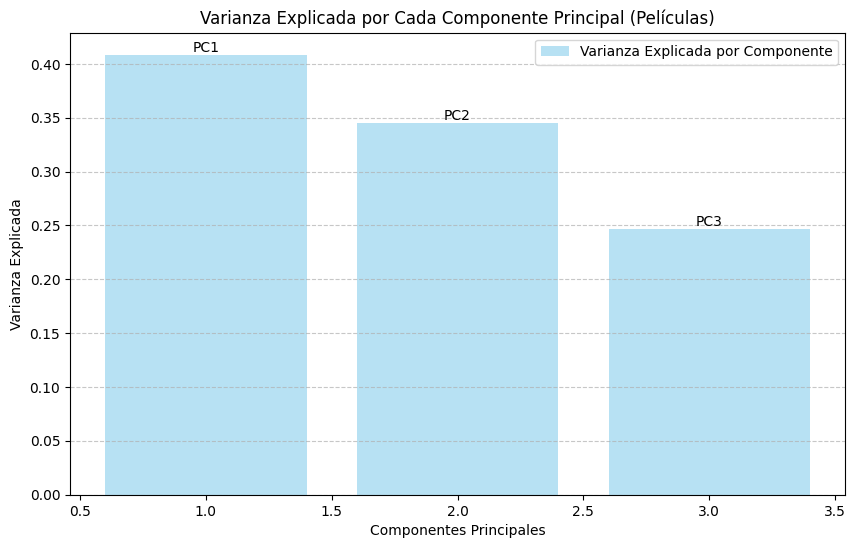

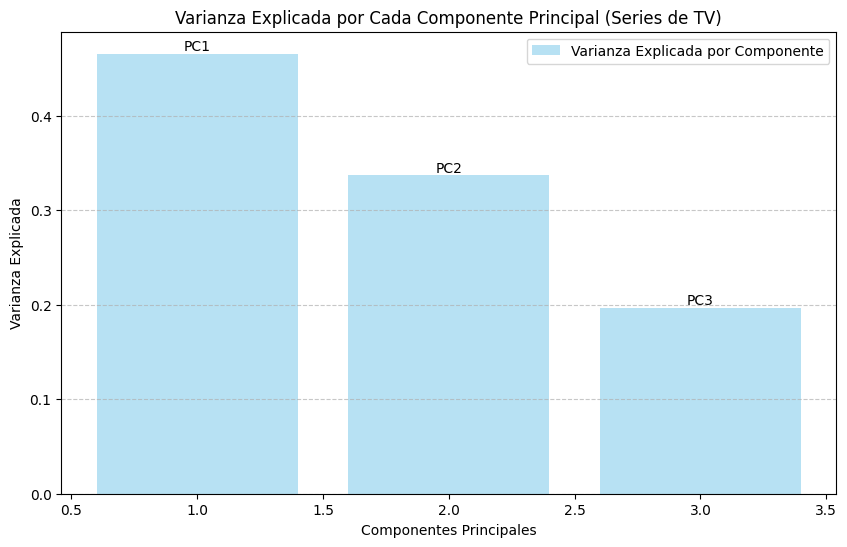

In [81]:
# Análisis de PCA para Películas y Series de TV
data_movies = prepare_data_for_pca(df, 'Movie')
pca_movies, pca_df_movies, loadings_movies = perform_pca(data_movies)

data_tv_shows = prepare_data_for_pca(df, 'TV Show')
pca_tv_shows, pca_df_tv_shows, loadings_tv_shows = perform_pca(data_tv_shows)

# Determinar el número de componentes para películas y series de TV
n_components_movies = determine_n_components(pca_movies)
n_components_tv_shows = determine_n_components(pca_tv_shows)

# Realizar PCA con el número óptimo de componentes
pca_movies, pca_df_movies, loadings_movies = perform_pca(data_movies, n_components=n_components_movies)
pca_tv_shows, pca_df_tv_shows, loadings_tv_shows = perform_pca(data_tv_shows, n_components=n_components_tv_shows)

# Mostrar los resultados del PCA para películas
print(f"Componentes Principales para Películas (n={n_components_movies})")
display(pca_df_movies.head())
print("Cargas de los Componentes Principales para Películas")
display(loadings_movies)

# Mostrar los resultados del PCA para series de TV
print(f"Componentes Principales para Series de TV (n={n_components_tv_shows})")
display(pca_df_tv_shows.head())
print("Cargas de los Componentes Principales para Series de TV")
display(loadings_tv_shows)

# Graficar la varianza explicada para películas con etiquetas de componentes
plot_pca_variance(pca_movies, 'Películas')

# Graficar la varianza explicada para series de TV con etiquetas de componentes
plot_pca_variance(pca_tv_shows, 'Series de TV')


# Conclusiones

## Películas

### Primer Componente Principal (PC1)
  PC1 captura la variabilidad en la duración de las películas en relación con el año de lanzamiento y de adición. Las películas más largas tienden a ser más antiguas y han sido añadidas recientemente.

### Segundo Componente Principal (PC2)
  PC2 captura principalmente la variabilidad en el año de adición a Netflix y, en menor medida, el año de lanzamiento. Este componente refleja cuándo fueron añadidas las películas a la plataforma.

### Tercer Componente Principal (PC3)
  PC3 captura una combinación de la duración y el año de lanzamiento de las películas, con un impacto inverso del año de adición. Este componente refleja películas con duraciones y años de lanzamiento diversos.

## Series de TV

### Primer Componente Principal (PC1)
  PC1 captura principalmente la variabilidad en los años de lanzamiento y adición de las series de TV, con poca influencia de la duración. Este componente refleja cuándo fueron lanzadas y añadidas las series a la plataforma.

### Segundo Componente Principal (PC2)
  PC2 captura principalmente la variabilidad en la duración de las series de TV, con poca influencia de los años de lanzamiento y adición. Este componente refleja la duración de las series.

### Tercer Componente Principal (PC3)
  PC3 captura una combinación de los años de lanzamiento y adición de las series de TV, con un impacto inverso de la duración. Este componente refleja series con años de lanzamiento y adición diversos.
